In [2]:
import numba as nb
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv, det
from scipy.optimize import minimize

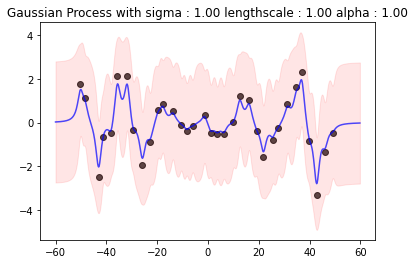

[   1.31002486    3.31172484 1026.85717433]


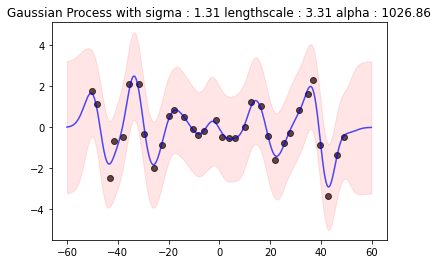

In [3]:
def load_data_GP(data_path):
    X = []
    Y = []
    with open(data_path, "r", encoding='utf-8') as file:
        for line in file:
            x, y = line.split(" ")
            X.append(float(x))
            Y.append(float(y))
        X = np.array(X).reshape(-1,1)
        Y = np.array(Y).reshape(-1,1)
    return X, Y


def rational_quadratic_kernel(X1, X2, sigma, lengthscale, alpha):
    dist_matrix = np.sum(X1**2,1).reshape(-1,1) + np.sum(X2**2,1) - 2 * X1 @ X2.T
    kernel = sigma ** 2 * ( (1 + ( (dist_matrix) / (2*alpha*(lengthscale**2))) ) ** -alpha)
    return kernel

def prior():
    pass

def posterior(X_s, X, Y, params, beta):
    """
    X_s: new input
    X:  training X
    Y:  training Y
    params: sigma, lengthscale, alpha
    """

    kernel = rational_quadratic_kernel(X, X, params[0], params[1], params[2]) + np.eye(len(X)) * (1/beta)
    kernel_s = rational_quadratic_kernel(X, X_s, params[0], params[1], params[2])
    kernel_ss = rational_quadratic_kernel(X_s, X_s, params[0], params[1], params[2]) + np.eye(len(X_s))

    kernel_inv = inv(kernel)
    
    # mu* = k*^T * ky^-1 * y
    mu_s = kernel_s.T @ kernel_inv @ Y

    # conv* = k** - k*^T * ky^-1 * k*
    conv_s = kernel_ss - kernel_s.T @ kernel_inv @ kernel_s

    return mu_s, conv_s

def negative_log_marginal_likelihood(params, X, Y, beta):
    
    Y = Y.ravel()
    #params = params.ravel()
    kernel = rational_quadratic_kernel(X, X, params[0], params[1], params[2]) + np.eye(len(X)) * (1/beta)
    
    kernel_inv = inv(kernel)

    nll = 0.5 * np.log(det(kernel)) + 0.5 * Y.T @ kernel_inv @ Y + 0.5 * len(X) * np.log(2*np.pi)

    return nll

def GP_plt(X_s, X, Y, mu_s, conv_s, params):
    
    plt.title(f"Gaussian Process with sigma : {params[0]:.2f} lengthscale : {params[1]:.2f} alpha : {params[2]:.2f}")
    plt.plot(X_s, mu_s, alpha=0.7, color="b")
    plt.scatter(X, Y, alpha=0.7, color="k")

    uncertainty = 1.96 * np.sqrt(np.diag(conv_s))

    X_s = X_s.ravel()
    mu_s = mu_s.ravel()

    plt.fill_between(X_s, mu_s - uncertainty, mu_s + uncertainty, alpha=0.1, color="r")
    plt.show()
    

def gaussian_process():
    X, Y = load_data_GP("data/input.data")
    X_s = np.arange(-60.0, 60.0, 0.2).reshape(-1,1)

    sigma = 1
    lengthscale = 1
    alpha = 1
    beta = 5
    params = [sigma, lengthscale, alpha]
    mu_s, conv_s = posterior(X_s, X, Y, params, beta)

    GP_plt(X_s, X, Y, mu_s, conv_s, params)

    res = minimize(fun=negative_log_marginal_likelihood,
            x0 = params,
            bounds=((1e-6,None),(1e-6,None),(1e-6,None)),
            args=(X, Y, beta), method='L-BFGS-B', options={}
            )

    print(res.x)

    mu_s, conv_s = posterior(X_s, X, Y, res.x, beta)

    GP_plt(X_s, X, Y, mu_s, conv_s, res.x)

gaussian_process()

In [4]:
import csv
from libsvm.svmutil import *

In [7]:
def get_data_SVM(data_path, mode = "train"):

    X = []
    with open(data_path + "X_" + mode + ".csv") as cvsfile:
        rows = csv.reader(cvsfile)
        for row in rows:
            X.append([float(x) for x in row])
    
    Y = []
    with open(data_path + "Y_" + mode + ".csv") as cvsfile:
        rows = csv.reader(cvsfile)
        for row in rows:
            Y.append(int(row[0]))

    return np.array(X), np.array(Y)

def grid_search():
    
    X_train, Y_train = get_data_SVM("data/", "train")
    X_test, Y_test = get_data_SVM("data/", "test")

    best_kernel_acc = {"linear":0, "polynomial":0, "RBF":0}    
    best_kernel_params = {"linear":f"", "polynomial":f"", "RBF":f""}

    kernel_mode = {"linear":0, "polynomial":1, "RBF":2}
    cost_list   = [0.001, 0.01, 0.1, 1, 10, 100]
    gamma_list  = [0.001, 0.01, 0.1, 1, 10, 100]

    for kernel, index in kernel_mode.items():
        print(kernel)
        for cost in cost_list:
            for gamma in gamma_list:
                params = f"-t {index} -c {cost} -g {gamma}"    
                if index == 0:
                    params = f"-t {index} -c {cost}"

                prob = svm_problem(Y_train,X_train)
                model = svm_train(prob, params)
                
                p_label, p_acc, p_val = svm_predict(Y_test, X_test, model)
                
                print(p_acc,params)

                if p_acc[0] >= best_kernel_acc[kernel]:
                    best_kernel_acc[kernel] = p_acc[0]
                    if index == 0:
                        best_kernel_params[kernel] = f"kernel: {kernel} cost: {cost}"
                    else:
                        best_kernel_params[kernel] = f"kernel: {kernel} cost: {cost} gamma: {gamma}"
                if index == 0:
                    break

        print(f"")
        print(f"best acc {best_kernel_acc[kernel]}")
        print(f"best model {best_kernel_params[kernel]}")
        print(f"")

    print(f"best acc {best_kernel_acc}")
    print(f"best model {best_kernel_params}")

def linear_kernel(X1,X2):
    kernel = X1 @ X2.T
    return kernel

def RBF_kernel(X1,X2,gamma):
    dist_matrix = np.sum(X1**2,1).reshape(-1,1) + np.sum(X2**2,1) - 2 * X1 @ X2.T
    kernel = np.exp(-gamma * dist_matrix)
    return kernel

def linear_RBF_kernel(X1,X2,gamma):
    kernel = np.add(linear_kernel(X1,X2), RBF_kernel(X1,X2,gamma))
    kernel = np.hstack((np.arange(1,len(X1)+1).reshape(-1,1),kernel))
    return kernel
                            
def part_1():
    X_train, Y_train = get_data_SVM("data/", "train")
    X_test, Y_test = get_data_SVM("data/", "test")

    kernel_mode = {"linear":"-t 0", "polynomial":"-t 1 -b 1", "RBF":"-t 2"}
    for kernel, params in kernel_mode.items():
        print(kernel)
        
        prob = svm_problem(Y_train,X_train)
        model = svm_train(prob, params)
        print(model)
        p_label, p_acc, p_val = svm_predict(Y_test, X_test, model)

        print(p_acc)

def part_2():

    grid_search()

def part_3():

    X_train, Y_train = get_data_SVM("data/", "train")
    X_test, Y_test = get_data_SVM("data/", "test")

    kernel = linear_RBF_kernel(X_train, X_train, 0.01)
    kernel_s = linear_RBF_kernel(X_test, X_train, 0.01)
    probelm = svm_problem(Y_train, kernel, isKernel=True)
    params = f"-t 4"
    model = svm_train(probelm, params)
    p_label, p_acc, p_val = svm_predict(Y_test, kernel_s, model)

    print(f"Linear + RBF kernel")
    print(p_acc)
    

#part_1()
# print(f"")
#part_2()
# print(f"")
part_3()

Accuracy = 95.32% (2383/2500) (classification)
Linear + RBF kernel
(95.32000000000001, 0.1324, 0.9350534525357612)
